## Step 1 Preparing training and test datasets

In [1]:
import pandas as pd

df = pd.read_csv("adm_notes_exclude_dead_readm.csv",
                     header=0)
data = pd.DataFrame()
data['label'] = (df['redays']<=30).astype('int')
data['summary'] = df['summary']
data.label.value_counts()
data_dropna=data.dropna()

In [2]:
data_dropna.shape

(1377, 2)

## Step 2 Preprocess text data

In [3]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df = df.fillna(' ')
    df = df.str.replace('\n',' ')
    df = df.str.replace('\r',' ')
    return df

In [4]:
import nltk
from nltk.tokenize import word_tokenize
import string

my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','t','that','of','y',]

def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    filtered_tokens = [w for w in tokens if not w in my_stop_words] 
    return filtered_tokens

d1 = preprocess_text(data_dropna['summary'])
summary=d1.apply(tokenizer_better)

In [5]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding,GRU
from keras.models import Sequential
import numpy as np

Using TensorFlow backend.


use below code to convert label to two columns (catogorical)

In [6]:
#预定义变量
MAX_SEQUENCE_LENGTH = 100    #最大序列长度
EMBEDDING_DIM = 200    #embdding 维度
VALIDATION_SPLIT = 0.16    #验证集比例
TEST_SPLIT = 0.2    #测试集比例
#keras的sequence模块文本序列填充
tokenizer = Tokenizer()
tokenizer.fit_on_texts(summary)
sequences = tokenizer.texts_to_sequences(summary)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
label = to_categorical(np.asarray(data_dropna['label']))
#label = np.asarray(data_dropna['label'])
print('Shape of data tensor:', data_text.shape)
print('Shape of label tensor:', label.shape)

Found 23189 unique tokens.
Shape of data tensor: (1377, 100)
Shape of label tensor: (1377, 2)


Get test data from original data, then upsample the positives and split training and validation datasets

In [7]:
# Split test dataset and upsampling training data
from sklearn.model_selection import train_test_split

x_train_pre,x_test,y_train_pre,y_test=train_test_split(pd.DataFrame(data_text),pd.DataFrame(label,columns=['No','Yes']),test_size=0.2)


X = pd.concat([x_train_pre, y_train_pre], axis=1)

# Divide by class
df_class_0 = X[X['Yes'] == 0]
df_class_1 = X[X['Yes'] == 1]

#Upsampling positive samples in training dataset
df_class_1_upsample = df_class_1.sample(df_class_0.shape[0], replace=True)

df_over = pd.concat([df_class_1_upsample, df_class_0], axis=0)
df_over.shape
# # shuffle the order of training samples 
df_all = df_over.sample(len(df_over['Yes']), random_state = 42).reset_index(drop = True)

#from df_all to get training and validation datasets
#p1 = int()*(1-VALIDATION_SPLIT)
p1 = int(df_all.shape[0]*(1-VALIDATION_SPLIT))

x_train = df_all.iloc[:,:-2][:p1]
y_train = df_all.iloc[:,[-2,-1]][:p1]
x_val = df_all.iloc[:,:-2][p1:]
y_val = df_all.iloc[:,[-2,-1]][p1:]

# Step 3 Training and evaluating model

In [8]:
#LSTM Model
MAX_SEQUENCE_LENGTH = 100   
EMBEDDING_DIM = 200    #embdding dimension

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(EMBEDDING_DIM, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dense(label.shape[1], activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          4638000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 4,965,298
Trainable params: 4,965,298
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# # fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# # evaluate the model
# loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

#### 1. Try loss='categorical_crossentropy' and optimizer='rmsprop' method

In [10]:
#Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc',recall_m,precision_m,f1_m])
print(model.metrics_names)
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)
model.save('lstm.h5')

['loss', 'acc', 'recall_m', 'precision_m', 'f1_m']


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1540 samples, validate on 294 samples
Epoch 1/10
1540/1540 [==============================] - 8s 5ms/step - loss: 0.6857 - acc: 0.5487 - recall_m: 0.5451 - precision_m: 0.5451 - f1_m: 0.5451 - val_loss: 0.6501 - val_acc: 0.6190 - val_recall_m: 0.5973 - val_precision_m: 0.5973 - val_f1_m: 0.5973
Epoch 2/10
1540/1540 [==============================] - 7s 5ms/step - loss: 0.6262 - acc: 0.6617 - recall_m: 0.6683 - precision_m: 0.6683 - f1_m: 0.6683 - val_loss: 0.6462 - val_acc: 0.6293 - val_recall_m: 0.6298 - val_precision_m: 0.6298 - val_f1_m: 0.6298
Epoch 3/10
1540/1540 [==============================] - 9s 6ms/step - loss: 0.5655 - acc: 0.7240 - recall_m: 0.7073 - precision_m: 0.7073 - f1_m: 0.7073 - val_loss: 0.5828 - val_acc: 0.6973 - val_recall_m: 0.6757 - val_precision_m: 0.6757 - val_f1_m: 0.6757
Epoch 4/10
1540/1540 [==============================] - 8s 6ms/step - loss: 0.5104 - acc: 0.7786 - recall_m: 0.7951 - precision_m: 0.7951 - f1_m: 0.7951 - val_loss: 0.5996 - val_a

In [11]:
loss, accuracy, recall, precision, f1 = model.evaluate(x_test, y_test, verbose=0)
print('loss {:.2f}, accuracy {:.2f}, recall {:.2f}, precision {:.2f}, f1 {:.2f}'.format(loss, accuracy, recall, precision, f1))

loss 0.78, accuracy 0.67, recall 0.68, precision 0.68, f1 0.68


In [14]:
model.predict_classes(x_test, verbose=1)

276/276 [==============================] - 1s 2ms/step


array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

#### 2.Try loss='binary_crossentropy',optimizer='SGD' method

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='SGD',
              metrics=['acc',recall_m,precision_m,f1_m])
print(model.metrics_names)
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)
model.save('lstm.h5')

['loss', 'acc', 'recall_m', 'precision_m', 'f1_m']
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1548 samples, validate on 296 samples
Epoch 1/10
1548/1548 [==============================] - 10s 6ms/step - loss: 0.6937 - acc: 0.4871 - recall_m: 0.4996 - precision_m: 0.4996 - f1_m: 0.4996 - val_loss: 0.6935 - val_acc: 0.4899 - val_recall_m: 0.4979 - val_precision_m: 0.4979 - val_f1_m: 0.4979
Epoch 2/10
1548/1548 [==============================] - 8s 5ms/step - loss: 0.6932 - acc: 0.5019 - recall_m: 0.5018 - precision_m: 0.5018 - f1_m: 0.5018 - val_loss: 0.6934 - val_acc: 0.4966 - val_recall_m: 0.5089 - val_precision_m: 0.5089 - val_f1_m: 0.5089
Epoch 3/10
1548/1548 [==============================] - 9s 6ms/step - loss: 0.6936 - acc: 0.5000 - recall_m: 0.4942 - precision_m: 0.4942 - f1_m: 0.4942 - val_loss: 0.6931 - val_acc: 0.4865 - val_recall_m: 0.4896 - val_precision_m: 0.4896 - val_f1_m: 0.4896
Epoch 4/10
1548/1548 [==============================] - 9s 6ms/step - loss: 0.6934 - acc: 0.5039 - recall_m: 0.5210 - precision_m: 0.5210 - f1_m: 0.5210 - val_loss: 0.6929 - val_

In [12]:
loss, accuracy, recall, precision, f1 = model.evaluate(x_test, y_test, verbose=0)
print('loss {:.2f}, accuracy {:.2f}, recall {:.2f}, precision {:.2f}, f1 {:.2f}'.format(loss, accuracy, recall, precision, f1))

loss 0.69, accuracy 0.58, recall 0.58, precision 0.58, f1 0.58


In [13]:
y_pred2 = model.predict_classes(x_test, verbose=1)

276/276 [==============================] - 1s 2ms/step


#### 3.Try loss='categorical_crossentropy',optimizer='adam' method

In [10]:
#模型编译
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc',recall_m,precision_m,f1_m])
print(model.metrics_names)
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)
model.save('lstm.h5')

['loss', 'acc', 'recall_m', 'precision_m', 'f1_m']


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1543 samples, validate on 295 samples
Epoch 1/10
1543/1543 [==============================] - 9s 6ms/step - loss: 0.6860 - acc: 0.5820 - recall_m: 0.5812 - precision_m: 0.5812 - f1_m: 0.5812 - val_loss: 0.6728 - val_acc: 0.6271 - val_recall_m: 0.6006 - val_precision_m: 0.6006 - val_f1_m: 0.6006
Epoch 2/10
1543/1543 [==============================] - 8s 5ms/step - loss: 0.6526 - acc: 0.6377 - recall_m: 0.6537 - precision_m: 0.6537 - f1_m: 0.6537 - val_loss: 0.6310 - val_acc: 0.6678 - val_recall_m: 0.6675 - val_precision_m: 0.6675 - val_f1_m: 0.6675
Epoch 3/10
1543/1543 [==============================] - 8s 5ms/step - loss: 0.5777 - acc: 0.7058 - recall_m: 0.7064 - precision_m: 0.7064 - f1_m: 0.7064 - val_loss: 0.5766 - val_acc: 0.7356 - val_recall_m: 0.7374 - val_precision_m: 0.7374 - val_f1_m: 0.7374
Epoch 4/10
1543/1543 [==============================] - 9s 6ms/step - loss: 0.5010 - acc: 0.7777 - recall_m: 0.7835 - precision_m: 0.7835 - f1_m: 0.7835 - val_loss: 0.5376 - val_a

In [11]:
loss, accuracy, recall, precision, f1 = model.evaluate(x_test, y_test, verbose=0)
print('loss {:.2f}, accuracy {:.2f}, recall {:.2f}, precision {:.2f}, f1 {:.2f}'.format(loss, accuracy, recall, precision, f1))

loss 0.75, accuracy 0.67, recall 0.67, precision 0.67, f1 0.67


In [12]:
y_pred3 = model.predict_classes(x_test, verbose=1)

276/276 [==============================] - 1s 3ms/step


In [40]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


print(classification_report(test_y, y_pred_bool))

276/276 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       236
           1       0.17      0.17      0.17        40

    accuracy                           0.76       276
   macro avg       0.52      0.52      0.52       276
weighted avg       0.76      0.76      0.76       276



#### 4.Try focal_loss,optimizer='adam' method

In [10]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [11]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [12]:
#模型编译
# model.compile(loss=focal_loss(alpha=.25, gamma=2),
#               optimizer='adam',
#               metrics=['acc',recall_m,precision_m,f1_m])
model.compile(loss=[binary_focal_loss(alpha=.25, gamma=3)], 
              metrics=['acc',recall_m,precision_m,f1_m], 
              optimizer='adam')

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)
model.save('lstm.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1528 samples, validate on 292 samples
Epoch 1/10
1528/1528 [==============================] - 9s 6ms/step - loss: 10.9643 - acc: 0.5471 - recall_m: 0.5475 - precision_m: 0.5475 - f1_m: 0.5475 - val_loss: 10.0448 - val_acc: 0.5993 - val_recall_m: 0.6088 - val_precision_m: 0.6088 - val_f1_m: 0.6088
Epoch 2/10
1528/1528 [==============================] - 8s 5ms/step - loss: 10.3999 - acc: 0.6446 - recall_m: 0.6444 - precision_m: 0.6444 - f1_m: 0.6444 - val_loss: 9.5632 - val_acc: 0.6062 - val_recall_m: 0.6073 - val_precision_m: 0.6073 - val_f1_m: 0.6073
Epoch 3/10
1528/1528 [==============================] - 8s 5ms/step - loss: 9.1436 - acc: 0.7317 - recall_m: 0.7319 - precision_m: 0.7319 - f1_m: 0.7319 - val_loss: 8.4079 - val_acc: 0.6986 - val_recall_m: 0.7109 - val_precision_m: 0.7109 - val_f1_m: 0.7109
Epoch 4/10
1528/1528 [==============================] - 8s 5ms/step - loss: 7.8727 - acc: 0.7742 - recall_m: 0.7740 - precision_m: 0.7740 - f1_m: 0.7740 - val_loss: 7.6598 - va

In [13]:
loss, accuracy, recall, precision, f1 = model.evaluate(x_test, y_test, verbose=0)
print('loss {:.2f}, accuracy {:.2f}, recall {:.2f}, precision {:.2f}, f1 {:.2f}'.format(loss, accuracy, recall, precision, f1))

loss 3.30, accuracy 0.70, recall 0.71, precision 0.71, f1 0.71


In [ ]:
y_pred4 = model.predict_classes(x_test, verbose=1)

Train on 1528 samples, validate on 292 samples
Epoch 1/100
1528/1528 [==============================] - 8s 5ms/step - loss: 0.5380 - acc: 0.9869 - recall_m: 0.9868 - precision_m: 0.9868 - f1_m: 0.9868 - val_loss: 15.0290 - val_acc: 0.8801 - val_recall_m: 0.8756 - val_precision_m: 0.8756 - val_f1_m: 0.8756
Epoch 2/100
1528/1528 [==============================] - 8s 5ms/step - loss: 0.4057 - acc: 0.9908 - recall_m: 0.9908 - precision_m: 0.9908 - f1_m: 0.9908 - val_loss: 15.3695 - val_acc: 0.8836 - val_recall_m: 0.8848 - val_precision_m: 0.8848 - val_f1_m: 0.8848
Epoch 3/100
1528/1528 [==============================] - 9s 6ms/step - loss: 0.5381 - acc: 0.9902 - recall_m: 0.9902 - precision_m: 0.9902 - f1_m: 0.9902 - val_loss: 11.8412 - val_acc: 0.9144 - val_recall_m: 0.9149 - val_precision_m: 0.9149 - val_f1_m: 0.9149
Epoch 4/100
1528/1528 [==============================] - 8s 5ms/step - loss: 0.4399 - acc: 0.9889 - recall_m: 0.9888 - precision_m: 0.9888 - f1_m: 0.9888 - val_loss: 18.0659

1528/1528 [==============================] - 13s 8ms/step - loss: 0.4021 - acc: 0.9882 - recall_m: 0.9883 - precision_m: 0.9883 - f1_m: 0.9883 - val_loss: 18.8162 - val_acc: 0.8767 - val_recall_m: 0.8796 - val_precision_m: 0.8796 - val_f1_m: 0.8796
Epoch 33/100
1528/1528 [==============================] - 11s 7ms/step - loss: 0.3668 - acc: 0.9895 - recall_m: 0.9895 - precision_m: 0.9895 - f1_m: 0.9895 - val_loss: 18.9567 - val_acc: 0.8870 - val_recall_m: 0.8874 - val_precision_m: 0.8874 - val_f1_m: 0.8874
Epoch 34/100
1528/1528 [==============================] - 11s 7ms/step - loss: 0.3754 - acc: 0.9908 - recall_m: 0.9908 - precision_m: 0.9908 - f1_m: 0.9908 - val_loss: 20.6857 - val_acc: 0.8699 - val_recall_m: 0.8744 - val_precision_m: 0.8744 - val_f1_m: 0.8744
Epoch 35/100
1528/1528 [==============================] - 10s 7ms/step - loss: 0.4128 - acc: 0.9895 - recall_m: 0.9895 - precision_m: 0.9895 - f1_m: 0.9895 - val_loss: 16.5239 - val_acc: 0.8904 - val_recall_m: 0.8900 - val_prec

1528/1528 [==============================] - 8s 5ms/step - loss: 0.3747 - acc: 0.9902 - recall_m: 0.9901 - precision_m: 0.9901 - f1_m: 0.9901 - val_loss: 24.7695 - val_acc: 0.8596 - val_recall_m: 0.8666 - val_precision_m: 0.8666 - val_f1_m: 0.8666
Epoch 64/100
1528/1528 [==============================] - 7s 5ms/step - loss: 0.6054 - acc: 0.9908 - recall_m: 0.9909 - precision_m: 0.9909 - f1_m: 0.9909 - val_loss: 12.2478 - val_acc: 0.9349 - val_recall_m: 0.9306 - val_precision_m: 0.9306 - val_f1_m: 0.9306
Epoch 65/100
1528/1528 [==============================] - 7s 5ms/step - loss: 1.0681 - acc: 0.9843 - recall_m: 0.9843 - precision_m: 0.9843 - f1_m: 0.9843 - val_loss: 14.3645 - val_acc: 0.8904 - val_recall_m: 0.8967 - val_precision_m: 0.8967 - val_f1_m: 0.8967
Epoch 66/100
1528/1528 [==============================] - 8s 5ms/step - loss: 0.4470 - acc: 0.9935 - recall_m: 0.9934 - precision_m: 0.9934 - f1_m: 0.9934 - val_loss: 16.7797 - val_acc: 0.9007 - val_recall_m: 0.9112 - val_precisio

1528/1528 [==============================] - 7s 5ms/step - loss: 0.4012 - acc: 0.9908 - recall_m: 0.9909 - precision_m: 0.9909 - f1_m: 0.9909 - val_loss: 23.0849 - val_acc: 0.8801 - val_recall_m: 0.8889 - val_precision_m: 0.8889 - val_f1_m: 0.8889
Epoch 95/100
1528/1528 [==============================] - 8s 5ms/step - loss: 0.7845 - acc: 0.9895 - recall_m: 0.9895 - precision_m: 0.9895 - f1_m: 0.9895 - val_loss: 18.0236 - val_acc: 0.8801 - val_recall_m: 0.8822 - val_precision_m: 0.8822 - val_f1_m: 0.8822
Epoch 96/100
1528/1528 [==============================] - 8s 5ms/step - loss: 0.6533 - acc: 0.9843 - recall_m: 0.9842 - precision_m: 0.9842 - f1_m: 0.9842 - val_loss: 18.5536 - val_acc: 0.8938 - val_recall_m: 0.8927 - val_precision_m: 0.8927 - val_f1_m: 0.8927
Epoch 97/100
1528/1528 [==============================] - 8s 5ms/step - loss: 0.6267 - acc: 0.9902 - recall_m: 0.9902 - precision_m: 0.9902 - f1_m: 0.9902 - val_loss: 24.5584 - val_acc: 0.8596 - val_recall_m: 0.8466 - val_precisio

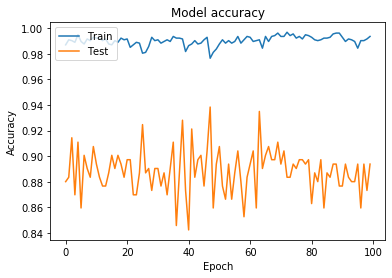

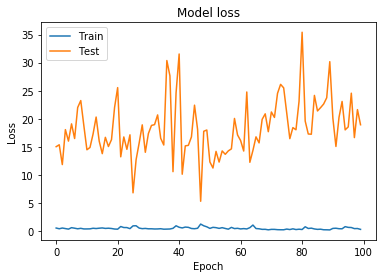

In [16]:
import matplotlib.pyplot as plt

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=, batch_size=128)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(test_y, y_pred_bool))

276/276 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       236
           1       0.17      0.17      0.17        40

    accuracy                           0.76       276
   macro avg       0.52      0.52      0.52       276
weighted avg       0.76      0.76      0.76       276



In [44]:
y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, y_pred_bool)

array([[202,  34],
       [ 33,   7]])